In [2]:
import pypylon.pylon as py
import numpy as np
import matplotlib.pyplot as plt
import traceback
import time
import cv2
import random

In [3]:
tlf = py.TlFactory.GetInstance()
cam = py.InstantCamera(tlf.CreateFirstDevice())
cam.Open()

In [4]:
cam.UserSetSelector = 'Default'
cam.UserSetLoad.Execute()

In [5]:
cam.ExposureAuto = 'Off'
# cam.PixelFormat = 'YCbCr422_8'
cam.PixelFormat = 'BayerGB8'
cam.ExposureTime = 30000
cam.AcquisitionFrameRate = 30
cam.BslBrightness = 0.4
cam.BslContrast = 0.4

In [6]:
print("resulting frame rate = ", cam.ResultingFrameRate.Value)
print(cam.Height.Value, cam.Width.Value)
print("pixel format = ", cam.PixelFormat.Value)

resulting frame rate =  30.00030000300003
1080 1920
pixel format =  BayerGB8


In [7]:
cam.PixelFormat.Symbolics

('RGB8', 'YCbCr422_8', 'BayerGB8', 'BayerGB12')

In [8]:
converter = py.ImageFormatConverter()
converter.OutputPixelFormat = py.PixelType_RGB8packed
converter.OutputBitAlignment = "MsbAligned"


In [9]:
def GrabOneSample():
    # fetch some images with foreground loop
    cam.PixelFormat = 'YCbCr422_8'
    # cam.PixelFormat = 'RGB8'
    img_sum = np.zeros((cam.Height.Value, cam.Width.Value,3), dtype=np.uint16)
    img = cam.GrabOne(1000)
    if (~converter.ImageHasDestinationFormat(img)):
        print("wrong")
        print((img.Array).shape)
    img = converter.Convert(img)
    if (~converter.ImageHasDestinationFormat(img)):
        print("wrong")
    frame = img.GetArray()
    print(img.GetBuffer()[:100])
    print(frame.shape)
    print(type(frame[0][0][0]))
    plt.imshow(frame)
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB )
    print(type(frame[0][0][0]))
    cv2.imshow("aa",frame)
    cv2.waitKey(0)
    
    # frame = img.Array
    # frame = img.Array
    # print(frame.shape)

    # for i in range(10):
    #     with cam.GrabOne(1000) as res:
    #         img = res.Array
    #         # if (~converter.ImageHasDestinationFormat(img)):
    #         img = converter.Convert()
    #         img_sum += img
    # return img_sum

wrong
(1080, 1920, 2)
wrong
bytearray(b'Q_RP^QI_]AWUB]dC^eKZaCRYHTbJVdPQcGHZRHaXNgWKcTH`YQ\\VNYZJdVF`[@m_DqTOcSNbJZWHXUDW]FY_PbdHZ\\E^XD]WEZ_F')
(1080, 1920, 3)
<class 'numpy.uint8'>
<class 'numpy.uint8'>


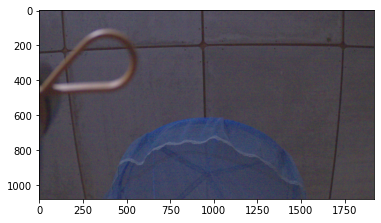

In [10]:
# %timeit GrabOneSample()
GrabOneSample()

In [11]:
def ForegroundLoopSample():
    img_sum = np.zeros((cam.Height.Value, cam.Width.Value,2), dtype=np.uint16)
    cam.StartGrabbingMax(10)
    while cam.IsGrabbing():
        with cam.RetrieveResult(1000) as res:
            if res.GrabSucceeded():
                img = res.Array
                img_sum += img
            else:
                raise RuntimeError("Grab failed")
    cam.StopGrabbing()
    return img_sum

In [12]:
cam.Width.Value

1920

In [13]:
%timeit ForegroundLoopSample()

433 ms ± 5.99 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
class ImageHandler (py.ImageEventHandler):
    def __init__(self, *args):
        super().__init__(*args)
        self.img_sum = np.zeros((cam.Height.Value, cam.Width.Value,3), dtype=np.uint16)
        self.time_old = time.time()
    
    def OnImageGrabbed(self, camera, grabResult):
        try:
            if grabResult.GrabSucceeded():
                
                if (~converter.ImageHasDestinationFormat(grabResult)):
                    grabResult = converter.Convert(grabResult)
                    
                img = grabResult.Array
                print(img.shape)
                time_new = time.time()
                # self.img_sum += img
                rate = 1/(time_new-self.time_old)
                print(rate)
                self.time_old = time_new
            else:
                raise RuntimeError("Grab failed")
        except Exception as e:
            traceback.print_exc()

In [15]:
def BackgroundLoopSample():
    handler = ImageHandler()

    cam.RegisterImageEventHandler(handler, py.RegistrationMode_ReplaceAll, py.Cleanup_None)

    cam.StartGrabbingMax(100, py.GrabStrategy_LatestImages, py.GrabLoop_ProvidedByInstantCamera)

    while cam.IsGrabbing():
        # cam.ExposureTime = random.uniform(cam.ExposureTime.Min,1000)
        time.sleep(0.1)

    cam.StopGrabbing()
    cam.DeregisterImageEventHandler(handler)
    cv2.destroyAllWindows()

    # return handler.img_sum


In [28]:
cam.ResultingFrameRate.Value

30.00030000300003

In [16]:
cam.ExposureTime.Value

30000.0

In [17]:
BackgroundLoopSample()

(1080, 1920, 3)
9.033004473102162
(1080, 1920, 3)
33.42287954610652
(1080, 1920, 3)
29.490416660807448
(1080, 1920, 3)
30.384259862940265
(1080, 1920, 3)
28.647660678915376
(1080, 1920, 3)
31.333746703620974
(1080, 1920, 3)
29.48979462697481
(1080, 1920, 3)
31.33398078560863
(1080, 1920, 3)
27.85228864938808
(1080, 1920, 3)
28.647465012874715
(1080, 1920, 3)
40.57642597322189
(1080, 1920, 3)
28.323624945132863
(1080, 1920, 3)
29.088730147721755
(1080, 1920, 3)
30.597044104988257
(1080, 1920, 3)
28.67723695635824
(1080, 1920, 3)
29.48979462697481
(1080, 1920, 3)
30.96615675388341
(1080, 1920, 3)
31.030073463590025
(1080, 1920, 3)
30.837522883841984
(1080, 1920, 3)
29.17228763988677
(1080, 1920, 3)
30.236191409910756
(1080, 1920, 3)
29.75168999198451
(1080, 1920, 3)
31.78442115473511
(1080, 1920, 3)
29.917856684308887
(1080, 1920, 3)
29.767526365842926
(1080, 1920, 3)
30.20570654913653
(1080, 1920, 3)
30.243604164864006
(1080, 1920, 3)
28.387844331641286
(1080, 1920, 3)
31.80683714017047

In [37]:
res = cam.GrabOne(1000)

17301514

In [19]:
cam.PixelFormat.Symbolics

('RGB8', 'YCbCr422_8', 'BayerGB8', 'BayerGB12')

In [57]:
cam.PixelFormat = 'YCbCr422_8'
cam.ExposureTime = 20000
res = cam.GrabOne(1000)
img = res.GetArray()
img.shape
# img = cv2.cvtColor(img, cv2.COLOR_YCrCb2RGB)
# plt.imshow(img)

(1080, 1920, 2)

In [60]:
cam.Open()

In [143]:
cam.IsGrabbing()

True

In [144]:
cam.StopGrabbing()

In [11]:
cam.Close()

In [13]:
cam.IsOpen()

False